In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

/home/djinb1127/miniconda3/envs/huggingface/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_model(input):
  source = {'CodeBERT_small' : {'tokenizer' : "huggingface/CodeBERTa-small-v1", 'model':"huggingface/CodeBERTa-small-v1"},
            'CodeBERT' : {'tokenizer' : "microsoft/codebert-base", 'model':"microsoft/codebert-base"},
            'GraphCodeBERT' : {'tokenizer' : "microsoft/graphcodebert-base", 'model':"microsoft/graphcodebert-base"},
            'Fine-tuning_Example' : {'tokenizer':"mrm8488/codebert-finetuned-clone-detection", 'model':"mrm8488/codebert-finetuned-clone-detection"}
  }
  
  if input in source.keys():
    tokenizer = source[input]['tokenizer']
    model = source[input]['model']
  else:
    print('Return None Obejects')
    print('Models :', source.keys())
    return None, None
  
  return tokenizer, model

In [3]:
tokenizer_path, model_path = select_model('CodeBERT')

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [4]:
from torch.utils.data import Dataset, DataLoader

class Code():
    def __init__(self, path, test_size):
        self.path = path
        self.test_size = test_size
            
    def openFile(self):
        df = pd.read_csv(self.path+'sample_train.csv')
        df = df.sample(frac=1).reset_index(drop=True) # shuffle

        # dataframe to ndarray
        ndarray = pd.DataFrame.to_numpy(df)

        # train/valid/test
        train = ndarray[:-2*self.test_size]
        valid = ndarray[-2*self.test_size:-self.test_size]
        test = ndarray[-self.test_size:]

        return train, valid, test

class code_dataset(Dataset):
    def __init__(self, data):

        input_ids = []
        attn_masks = []

        for i in range(len(data)):
            tmp = tokenizer(data[i, 0], data[i,1], padding='max_length', truncation=True, return_tensors='pt')
            input_ids.append(tmp['input_ids'])
            attn_masks.append(tmp['attention_mask'])
        
        self.input_ids = torch.cat(input_ids, out=torch.Tensor(len(input_ids), 512)).type(torch.LongTensor)
        self.attn_masks = torch.cat(attn_masks, out=torch.Tensor(len(attn_masks), 512)).type(torch.LongTensor)
        self.labels =  torch.from_numpy(data[:, 2].astype(int))

    def __getitem__(self, index):
        return self.input_ids[index], self.attn_masks[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

def dataset_loader(path, test_size, batch_size):
    code = Code(path, test_size=test_size)

    train, valid, test = code.openFile()

    train_dataset = code_dataset(train)
    valid_dataset = code_dataset(valid)
    test_dataset = code_dataset(test)

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

    return train_loader, valid_loader, test_loader

def dataloader_testing():
    # dataloader test
    path = './data/'
    train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=3) # batch_size = 3 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data[0]))
    print('input_ids: ', type(data[0]),'\n', data[0])
    print('attn_masks :', type(data[1]),'\n', data[1])
    print('labels :', type(data[2]),'\n', data[2])

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=False, num_labels=2)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

In [6]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [7]:
path = './data/'
train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=32) # batch size = 32

In [7]:
loss_fn = nn.BCELoss()

def cal_acc_and_loss(device, total_logits, labels_for_loss, pred, true):
    correct = 0
    count = 0
    total_loss = 0
    num_batch = 0

    for i in range(len(pred)):
        pred_i = pred[i]
        true_i = true[i]
        
        correct += np.sum(pred_i == true_i)
        total_loss += loss_fn(total_logits[i].to('cpu'), labels_for_loss[i].to('cpu').float())

        count += len(pred_i)
        num_batch += 1
    
    acc = correct/count
    loss = total_loss/num_batch

    return correct, total_loss, count, num_batch, acc, loss

In [8]:
def performance(model, device, data_loader):
    total_logits, labels_for_loss, predictions , true_labels = [], [], [], []

    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        label_ids = b_labels

        activation = nn.Softmax(dim=1)
        logits = activation(logits)
        
        tmp_logits = torch.max(logits, dim=1)

        logits = torch.abs(tmp_logits[0] + tmp_logits[1]-1)
        pred = tmp_logits[1]

        pred = pred.detach().cpu().numpy()

        total_logits.append(logits)
        labels_for_loss.append(label_ids)
        predictions.append(pred)
        true_labels.append(label_ids.to('cpu').numpy())

    correct, total_loss, count, num_batch, acc, loss = cal_acc_and_loss(device, total_logits, labels_for_loss, predictions, true_labels)

    return acc, round(float(loss), 4)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 8e-6, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

num_epochs = 5
step_count = 0
total_steps = num_epochs * len(train_loader)

model = model.to(device)

train_acc = []
valid_acc = []
train_loss = []
valid_loss = []
valid_loss_min = 1.0

loss_over_10_steps = []

model_path = './models/'
saved_at_step = 0

for epoch in range(num_epochs):
    for i, (input_ids, attn_masks, labels) in enumerate(train_loader):
        model.train()

        optimizer.zero_grad()

        input_ids = input_ids.to(device)
        attn_masks = attn_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=attn_masks, labels=labels)

        loss = outputs[0]

        loss.backward()
        
        loss_over_10_steps.append(loss.item())

        optimizer.step()

        if step_count%10 == 0:
            print('Step {} over {}'.format(step_count, total_steps))
            print(' Train Loss : ', np.mean(loss_over_10_steps))
            train_loss.append(np.mean(loss_over_10_steps))
            loss_over_10_steps = []
        
        # Report Validation Performance
        model.eval()
        if step_count%100 == 0:
            val_acc, val_loss = performance(model, device, valid_loader)
            print('     Report Performance on Validation Dataset...')
            print('     Valid Loss :', val_loss)
            print('     Valid Acc  :', val_acc)
            valid_acc.append(val_acc)
            valid_loss.append(val_loss)

            # save model
            if valid_loss_min > val_loss:
                valid_loss_min = val_loss
                print('         model saved')
                torch.save(model, model_path + 'model.pt')  # 전체 모델 저장
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, model_path + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능
                saved_at_step = step_count
        
        step_count = step_count + 1

Step 0 over 2500
 Train Loss :  0.682192862033844
     Report Performance on Validation Dataset...
     Valid Loss : 0.6881
     Valid Acc  : 0.54
         model saved
Step 10 over 2500
 Train Loss :  0.6874639868736268
Step 20 over 2500
 Train Loss :  0.7036250770092011
Step 30 over 2500
 Train Loss :  0.6955666959285736
Step 40 over 2500
 Train Loss :  0.7029762208461762
Step 50 over 2500
 Train Loss :  0.6980557084083557
Step 60 over 2500
 Train Loss :  0.6905807375907898
Step 70 over 2500
 Train Loss :  0.6818234086036682
Step 80 over 2500
 Train Loss :  0.679188895225525
Step 90 over 2500
 Train Loss :  0.6784524202346802
Step 100 over 2500
 Train Loss :  0.6803415060043335
     Report Performance on Validation Dataset...
     Valid Loss : 0.6862
     Valid Acc  : 0.524
         model saved
Step 110 over 2500
 Train Loss :  0.6823247790336608
Step 120 over 2500
 Train Loss :  0.6804237782955169
Step 130 over 2500
 Train Loss :  0.67542844414711
Step 140 over 2500
 Train Loss :  0.

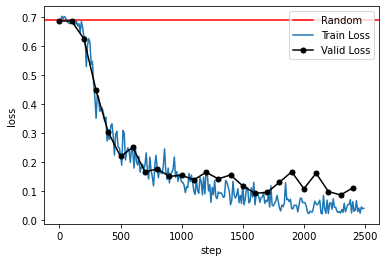

In [10]:
import matplotlib.pyplot as plt

train_x_axis = [10*i for i in range(len(train_loss))]
valid_x_axis = [100*i for i in range(len(valid_loss))]

plt.axhline(y=0.69, label='Random', color='red')
plt.plot(train_x_axis, train_loss, label='Train Loss')
plt.plot(valid_x_axis, valid_loss, marker='o', ms=5, color='black', label='Valid Loss')

plt.ylabel('loss')
plt.xlabel('step')

plt.legend(loc='upper right')

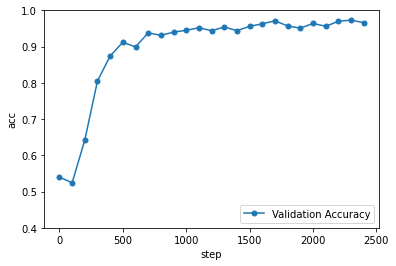

In [11]:
plt.plot(valid_x_axis, valid_acc, marker='o', ms=5, label='Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('step')
plt.ylim(0.4,1)
plt.legend(loc='lower right')

In [12]:
# Prediction on test set

print('Predicting labels for test dataset...')

# load model
model_path = './models/'
model = torch.load(model_path + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
checkpoint = torch.load(model_path + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Put model in evaluation mode
model.to(device)
model.eval()

test_acc, _ = performance(model, device, test_loader)

print('Test ACC : ', test_acc)

Predicting labels for test dataset...
Test ACC :  0.966


Submission File

In [13]:
class Test_Code():
    def __init__(self, path):
        self.path = path
            
    def openFile(self):
        df = pd.read_csv(self.path+'test.csv')

        # dataframe to ndarray
        data = pd.DataFrame.to_numpy(df)

        return data

class test_code_dataset(Dataset):
    def __init__(self, data):

        input_ids = []
        attn_masks = []

        for i in range(len(data)):
            tmp = tokenizer(data[i, 1], data[i,2], padding='max_length', truncation=True, return_tensors='pt')
            input_ids.append(tmp['input_ids'])
            attn_masks.append(tmp['attention_mask'])
        
        self.input_ids = torch.cat(input_ids, out=torch.Tensor(len(input_ids), 512)).type(torch.LongTensor)
        self.attn_masks = torch.cat(attn_masks, out=torch.Tensor(len(attn_masks), 512)).type(torch.LongTensor)
        self.pair_ids = torch.from_numpy(data[:, 0].astype(int))

    def __getitem__(self, index):
        return self.input_ids[index], self.attn_masks[index], self.pair_ids[index]

    def __len__(self):
        return len(self.pair_ids)

def test_dataset_loader(path, batch_size):
    code = Test_Code(path)

    data = code.openFile()

    dataset = test_code_dataset(data)

    data_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=False)

    return data_loader

def test_dataloader_testing():
    # dataloader test
    path = './'
    data_loader = test_dataset_loader(path=path, batch_size=16) # batch_size = 10 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data[0]))
    print('input_ids: ', type(data[0]),'\n', data[0])
    print('attn_masks :', type(data[1]),'\n', data[1])
    print('pair_ids :', type(data[2]), '\n', data[2])

In [14]:
path = './data/'
data_loader = test_dataset_loader(path=path, batch_size=16)

In [15]:
activation = nn.Softmax(dim=1)
predictions = []
pair_ids_list = []

model.eval()

count = 0

for batch in data_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_pair_ids = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = activation(logits)
    tmp_logits = torch.max(logits, dim=1)
    pred = tmp_logits[1]
    pred = pred.detach().cpu().numpy()
    predictions.append(pred)
    pair_ids_list = pair_ids_list + b_pair_ids.tolist()
    count += 1
    if count % 10 == 0:
        print('batch {} over {}'.format(count, len(data_loader)))

batch 10 over 11232
batch 20 over 11232
batch 30 over 11232
batch 40 over 11232
batch 50 over 11232
batch 60 over 11232
batch 70 over 11232
batch 80 over 11232
batch 90 over 11232
batch 100 over 11232
batch 110 over 11232
batch 120 over 11232
batch 130 over 11232
batch 140 over 11232
batch 150 over 11232
batch 160 over 11232
batch 170 over 11232
batch 180 over 11232
batch 190 over 11232
batch 200 over 11232
batch 210 over 11232
batch 220 over 11232
batch 230 over 11232
batch 240 over 11232
batch 250 over 11232
batch 260 over 11232
batch 270 over 11232
batch 280 over 11232
batch 290 over 11232
batch 300 over 11232
batch 310 over 11232
batch 320 over 11232
batch 330 over 11232
batch 340 over 11232
batch 350 over 11232
batch 360 over 11232
batch 370 over 11232
batch 380 over 11232
batch 390 over 11232
batch 400 over 11232
batch 410 over 11232
batch 420 over 11232
batch 430 over 11232
batch 440 over 11232
batch 450 over 11232
batch 460 over 11232
batch 470 over 11232
batch 480 over 11232
b

In [16]:
predictions_flat = [item for sublist in predictions for item in sublist]

In [17]:
import pickle

with open('./Results/predictions_5_18.pkl', 'wb') as f:
    pickle.dump(predictions_flat, f)

with open('./Results/pair_ids_5_18.pkl', 'wb') as f:
    pickle.dump(pair_ids_list, f)

In [18]:
print(len(predictions_flat))
print(len(pair_ids_list))

179700
179700


In [19]:
import csv

f = open('./submissions/submission_05_18.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['pair_id','similar'])
for i in range(len(pair_ids_list)):
     wr.writerow([pair_ids_list[i],predictions_flat[i]])
f.close()